In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


#### Load the Data

In [8]:
# load the dataset

data= pd.read_csv('merged.csv',parse_dates =True)


### 1.	Isolate the Rossmann Store Sales dataset into time series data

In [10]:
#Isolate the time series data
data= data.groupby("Date").agg({'Sales':'mean'})

data.head()

,Sales
Date,
2013-01-01,76.857271
2013-01-02,6050.476233
2013-01-03,5577.322870
2013-01-04,5832.756054
2013-01-05,5178.539910


### 2.Check whether your time Series Data is Stationary

In [12]:
#Check the Stationarity

# Use the Augumented Dicky-Fuller test
def check_stationarity(timeseries):
  # perform the dickey fuller test
  result = adfuller(timeseries, autolag='AIC')

  # Display the results
  print('ADF Statistics:', result[0])
  print('p-value:', result[1])
  print('Critical Values:', result[4])


  # Interprest the results
  if result[1] <= 0.05:
    print('The time series data is stationary')
  else:
    print('The time series data is not stationary')

# Check the stationarity
check_stationarity(data['Sales'])

ADF Statistics: -6.005160393292821
p-value: 1.6220661626191228e-07
Critical Values: {'1%': -3.4374778690219956, '5%': -2.864686684217556, '10%': -2.5684454926748583}
The time series data is stationary


### 3.Depending on your conclusion from 2 above difference your time series data

Since the data is already stationary, we skip the differencing step

### 4.Check for autocorrelation and partial autocorrelation of your data

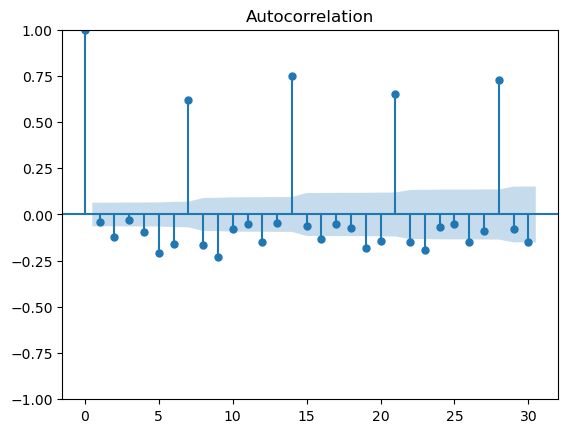

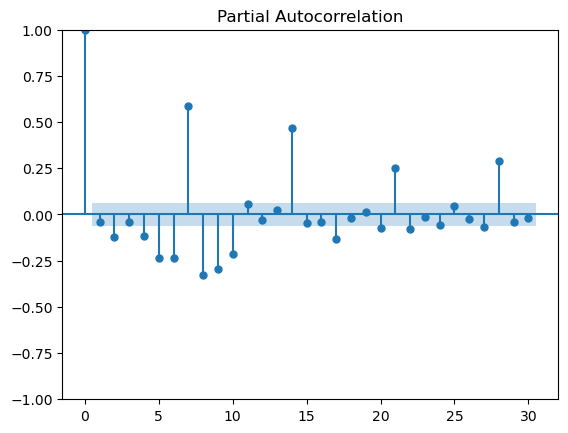

In [15]:
# Check for autocorrelation and partial autocorrelation
def plot_acf_pacf(data):
    plot_acf(data, lags=30)
    plt.show()
    plot_pacf(data, lags=30)
    plt.show()

plot_acf_pacf(data['Sales'])

### 5.Transform the time series data into supervised learning data by creating a new y(target) column

In [16]:
# Transform the time series data into supervised learning data
def create_supervised_data(data, lag=1):
    df = pd.DataFrame(data.copy())
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

lag = 7  
supervised_data = create_supervised_data(data, lag)


### 6.Scale your data in the (-1, 1) range

In [17]:
# Scale the data in the (-1, 1) range
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(supervised_data)


In [18]:
# Split the data into features and target
X = scaled_data[:, :-1]
y = scaled_data[:, -1]


In [19]:
# Reshape the input data for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], lag, 1)


In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 7.Build a LSTM Regression model to predict the next sale. 

In [22]:
# Build LSTM Regression model
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50

24/24 [==============================] - 5s 43ms/step - loss: 0.3788 - val_loss: 0.2816
Epoch 2/50
24/24 [==============================] - 0s 9ms/step - loss: 0.3325 - val_loss: 0.2546
Epoch 3/50
24/24 [==============================] - 0s 9ms/step - loss: 0.3056 - val_loss: 0.2416
Epoch 4/50
24/24 [==============================] - 0s 10ms/step - loss: 0.2861 - val_loss: 0.2263
Epoch 5/50
24/24 [==============================] - 0s 9ms/step - loss: 0.2565 - val_loss: 0.1974
Epoch 6/50
24/24 [==============================] - 0s 8ms/step - loss: 0.2170 - val_loss: 0.1678
Epoch 7/50
24/24 [==============================] - 0s 9ms/step - loss: 0.1883 - val_loss: 0.1600
Epoch 8/50
24/24 [==============================] - 0s 9ms/step - loss: 0.1839 - val_loss: 0.1558
Epoch 9/50
24/24 [==============================] - 0s 9ms/step - loss: 0.1851 - val_loss: 0.1547
Epoch 10/50
24/24 [==============================] - 0s 10ms/step - loss: 0.1783 - val_loss: 0.1529
Epoch 11/50
24/

In [24]:
# Make predictions on the test set
y_pred = model.predict(X_test)


6/6 [==============================] - 1s 6ms/step


In [25]:
# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, :, :].reshape(X_test.shape[0], lag), y_pred.reshape(y_pred.shape[0], 1)), axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate((X_test[:, :, :].reshape(X_test.shape[0], lag), y_test.reshape(y_test.shape[0], 1)), axis=1))[:, -1]


In [26]:
# Calculate and print the Mean Squared Error
mse = mean_squared_error(y_test_inv, y_pred_inv)
print('Mean Squared Error:', mse)

Mean Squared Error: 1775106.8703004015


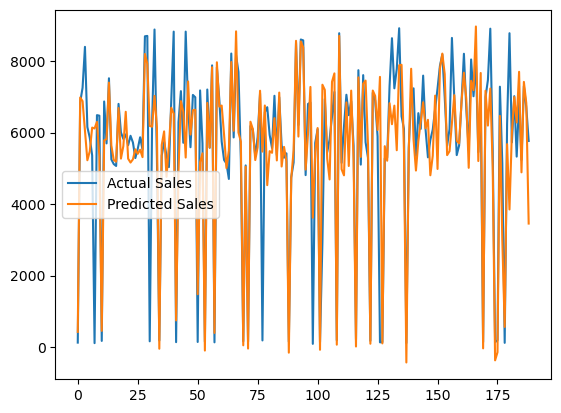

In [27]:
# Plot the actual vs. predicted values
plt.plot(y_test_inv, label='Actual Sales')
plt.plot(y_pred_inv, label='Predicted Sales')
plt.legend()
plt.show()